In [12]:
import requests
import rasterio

from rasterio.features import geometry_mask
import numpy as np
import geopandas as gpd
from shapely.geometry import shape, Polygon, MultiPolygon, LineString, MultiLineString
from shapely.geometry import mapping
import matplotlib.pyplot as plt
import os

# PDOK API Base URL


# Define bounding box (Amersfoort RD New coordinates - EPSG:28992)
bbox = "94500,469500,95000,470000"  # xmin, ymin, xmax, ymax
crs = "http://www.opengis.net/def/crs/EPSG/0/28992"
item_type = "waterdeel_vlak"

def get_top10nl(bbox, crs, item_type):
    BASE_URL = "https://api.pdok.nl/brt/top10nl/ogc/v1"
    # API Request URL
    url = f"{BASE_URL}/collections/{item_type}/items?bbox={bbox}&bbox-crs={crs}&crs={crs}&limit=1000&f=json"
    
    # Send GET request
    response = requests.get(url)
    
    # Check response
    if response.status_code == 200:
       data = response.json()
    else:
        print(f"Error: {response.status_code}, {response.text}")
    return data
    

In [29]:
import json
# Fetch the water data for both polygons and lines
waterdata_vlak = get_top10nl(bbox, crs, "waterdeel_vlak")  # Polygons
waterdata_lijn = get_top10nl(bbox, crs, "waterdeel_lijn")  # Lines
print(waterdata_lijn.get("crs"))

water_features = []

# Process polygon features from "waterdeel_vlak"
for wat in waterdata_vlak.get("features", []):
    geom = shape(wat['geometry'])
    properties = wat.get("properties", {})

    if properties.get("hoogteniveau") == -1:
        continue

    if isinstance(geom, (Polygon, MultiPolygon)):
        water_features.append({
            "type": "Feature",
            "geometry": mapping(geom),  # Convert Shapely geometry to GeoJSON format
            "properties": properties # Preserve original properties
        })

# Process line features from "waterdeel_lijn" (buffer by 0.5 meters)
for wat in waterdata_lijn.get("features", []):
    geom = shape(wat['geometry'])
    properties = wat.get("properties", {})

    if properties.get("hoogteniveau") == -1:
        continue


    # Buffer lines to create polygons
    if isinstance(geom, (LineString, MultiLineString)):
        geom = geom.buffer(0.5)

    # Add buffered lines as polygons
    if isinstance(geom, (Polygon, MultiPolygon)):
        water_features.append({
            "type": "Feature",
            "geometry": mapping(geom),  # Convert Shapely geometry to GeoJSON format
            "properties": properties # Preserve original properties
        })

geojson_data = {
    "type": "FeatureCollection",
    "crs": {
        "type": "name",
        "properties": {"name": "urn:ogc:def:crs:EPSG::28992"}
    },
    "features": water_features
}

# Save to a GeoJSON file
output_path = "water_geometries_28992.geojson"
with open(output_path, "w", encoding="utf-8") as f:
    json.dump(geojson_data, f, ensure_ascii=False, indent=4)


None


In [67]:
wegdata = get_top10nl(bbox, crs, "wegdeel_vlak")
landuse_road_mapping = {}

with open("top10nlroad_types.txt", "r", encoding="utf-8") as f:
    f.readline()
    for line in f:
        print(line)
        parts = line.strip().split("\t")  # Tab-separated values
        print(parts)
        if len(parts) == 2:
            verhardingstype, landuse_code = parts
            landuse_road_mapping[verhardingstype.lower()] = int(landuse_code)  # Store in dictionary
print(landuse_road_mapping)

road_features = []

# Process terrain features
for road in wegdata.get("features", []):
    geom = shape(road['geometry'])
    properties = road.get("properties", {})  # Extract original properties
    # Get "typelandgebruik" and determine "landuse"
    typelandgebruik = properties.get("verhardingstype", "").lower()
    landuse_value = landuse_road_mapping.get(verhardingstype)

    new_properties = {"landuse": landuse_value} if landuse_value is not None else {}

    if isinstance(geom, (Polygon, MultiPolygon)):
        road_features.append({
            "type": "Feature",
            "geometry": mapping(geom),
            "properties": new_properties
        })

# Create GeoJSON feature collection with CRS EPSG:28992
geojson_data = {
    "type": "FeatureCollection",
    "crs": {
        "type": "name",
        "properties": {"name": "urn:ogc:def:crs:EPSG::28992"}
    },
    "features": road_features
}

# Save to a GeoJSON file
output_path = "road_geometries_28992.geojson"
with open(output_path, "w", encoding="utf-8") as f:
    json.dump(geojson_data, f, ensure_ascii=False, indent=4)

print(f"GeoJSON saved with CRS EPSG:28992 at {output_path}")

verhard	1		

['verhard', '1']
half verhard	0		

['half verhard', '0']
onverhard	6		

['onverhard', '6']
onbekend	1
['onbekend', '1']
{'verhard': 1, 'half verhard': 0, 'onverhard': 6, 'onbekend': 1}
GeoJSON saved with CRS EPSG:28992 at road_geometries_28992.geojson


In [64]:
import json
from shapely.geometry import shape, mapping, Polygon, MultiPolygon

# Load the mapping from TXT file
landuse_mapping = {}

with open("top10nl_types.txt", "r", encoding="utf-8") as f:
    f.readline()
    for line in f:
        print(line)
        parts = line.strip().split("\t")  # Tab-separated values
        print(parts)
        if len(parts) == 2:
            typelandgebruik, landuse_code = parts
            landuse_mapping[typelandgebruik.lower()] = int(landuse_code)  # Store in dictionary
print(landuse_mapping)
# Fetch terrain data
terreindata = get_top10nl(bbox, crs, "terrein_vlak")

terrein_features = []

# Process terrain features
for ter in terreindata.get("features", []):
    geom = shape(ter['geometry'])
    properties = ter.get("properties", {})  # Extract original properties
    # Get "typelandgebruik" and determine "landuse"
    typelandgebruik = properties.get("typelandgebruik", "").lower()
    landuse_value = landuse_mapping.get(typelandgebruik)

    # Skip if "hoogteniveau" == -1
    if properties.get("hoogteniveau") == -1:
        continue

    # Create new property "landuse" if a valid mapping exists
    new_properties = {"landuse": landuse_value} if landuse_value is not None else {}

    if isinstance(geom, (Polygon, MultiPolygon)):
        terrein_features.append({
            "type": "Feature",
            "geometry": mapping(geom),
            "properties": new_properties
        })

# Create GeoJSON feature collection with CRS EPSG:28992
geojson_data = {
    "type": "FeatureCollection",
    "crs": {
        "type": "name",
        "properties": {"name": "urn:ogc:def:crs:EPSG::28992"}
    },
    "features": terrein_features
}

# Save to a GeoJSON file
output_path = "terrein_geometries_28992.geojson"
with open(output_path, "w", encoding="utf-8") as f:
    json.dump(geojson_data, f, ensure_ascii=False, indent=4)

print(f"GeoJSON saved with CRS EPSG:28992 at {output_path}")

aanlegsteiger	0

['aanlegsteiger', '0']
akkerland	6

['akkerland', '6']
"basaltblokken, steenglooiing"	0

['"basaltblokken, steenglooiing"', '0']
bebouwd gebied	0

['bebouwd gebied', '0']
boomgaard	5

['boomgaard', '5']
boomkwekerij	5

['boomkwekerij', '5']
bos: gemengd bos	5

['bos: gemengd bos', '5']
bos: griend	5

['bos: griend', '5']
bos: loofbos	5

['bos: loofbos', '5']
bos: naaldbos	5

['bos: naaldbos', '5']
braakliggend	5

['braakliggend', '5']
dodenakker	5

['dodenakker', '5']
dodenakker met bos	5

['dodenakker met bos', '5']
duin	6

['duin', '6']
fruitkwekerij	5

['fruitkwekerij', '5']
grasland	5

['grasland', '5']
heide	5

['heide', '5']
overig	0

['overig', '0']
populieren	5

['populieren', '5']
spoorbaanlichaam	0

['spoorbaanlichaam', '0']
{'aanlegsteiger': 0, 'akkerland': 6, '"basaltblokken, steenglooiing"': 0, 'bebouwd gebied': 0, 'boomgaard': 5, 'boomkwekerij': 5, 'bos: gemengd bos': 5, 'bos: griend': 5, 'bos: loofbos': 5, 'bos: naaldbos': 5, 'braakliggend': 5, 'dodenakk

In [5]:
tifpath = "output/final_dtm.tif"

In [6]:
with rasterio.open(tifpath) as dst:
    array = dst.read(1)

In [ ]:
# Roofs              2
# Dark_asphalt       1 
# Cobble_stone_2014a 0  
# Water              7  
# Grass_unmanaged    5   
# bare_soil          6   

In [7]:
def load_buildings(buildings_path, layer):
    """
    Load in the building shapes from a geopackage file.
    ----
    Input:
    - buildings_path (string):   path to the geopackage file.
    - layer (string):            (Tile) name of the layer of buildings to be used

    Output:
    - List of dictionaries: A list of dictionaries containing:
      - "geometry": building geometry in GeoJSON-like format.
      - "parcel_id": corresponding parcel ID.
    """
    buildings_gdf = gpd.read_file(buildings_path, layer=layer)

    if 'identificatie' not in buildings_gdf.columns:
        raise ValueError("Column 'identificatie' not found in the dataset")

    return [{"geometry": mapping(geom), "parcel_id": identificatie} for geom, identificatie in zip(buildings_gdf.geometry, buildings_gdf["identificatie"])]

In [8]:
buildingdata = load_buildings("output/buildtest.gpkg", "test")


In [14]:
from matplotlib.colors import ListedColormap, BoundaryNorm

def visualize_raster(raster_array):
    # Define discrete colors for each category
    cmap = ListedColormap(["gray", "blue", "black", "green", "brown", "yellow", "tan", "cyan"])  
    categories = [-9999, 0, 1, 2, 3, 4, 5, 6, 7]  # Define unique values in the raster
    
    norm = BoundaryNorm(categories, cmap.N)  # Ensures discrete mapping

    plt.figure(figsize=(6, 6))
    img = plt.imshow(raster_array, cmap=cmap, norm=norm, interpolation='nearest')
    
    # Define color bar with correct tick positions
    cbar = plt.colorbar(img, ticks=categories)
    cbar.set_label("Land Cover Type")
    
    plt.title("Discrete Raster Visualization")
    plt.show()

In [68]:
def convert_to_raster(array, water, roads, terrain, buildings, transform):
    array.fill(-9999)  # Initialize the array with no-data value (-9999)

    new_array = array.copy()  # Copy of the original array
    print(terrain)
    # Process terrain features
    for ter in terrain:
        try:
            geom = shape(ter['geometry'])
            if not geom.is_valid:
                print(f"Skipping invalid terrain geometry: {ter['geometry']}")
                continue

            landuse = ter['properties'].get('landuse', None)  # Get landuse property
            if landuse is not None:
                landuse_mask = geometry_mask([geom], transform=transform, invert=False, out_shape=array.shape)
                new_array = np.where(landuse_mask, new_array, landuse)

        except Exception as e:
            print(f"Error processing terrain feature: {e}")
            continue

    # Process road features
    for road in roads:
        try:
            geom = shape(road['geometry'])
            if not geom.is_valid:
                print(f"Skipping invalid terrain geometry: {road['geometry']}")
                continue

            landuse_road = ter['properties'].get('landuse', None)
            if landuse is not None:
                landuse_road_mask = geometry_mask([geom], transform=transform, invert=False, out_shape=array.shape)
                new_array = np.where(landuse_road_mask, new_array, landuse_road)

        except Exception as e:
            print(f"Error processing terrain feature: {e}")
            continue

    # Process building geometries
    try:
        building_geometries = [shape(building['geometry']) for building in buildings]
        building_mask = geometry_mask(building_geometries, transform=transform, invert=False, out_shape=array.shape)
        new_array = np.where(building_mask, new_array, 2)  # Assign value 2 for building areas
    except Exception as e:
        print(f"Error processing building geometries: {e}")

    # Process water features
    water_geometries = []

    for wat in water:
        try:
            geom = shape(wat['geometry'])
            if isinstance(geom, (LineString, MultiLineString)):
                geom = geom.buffer(0.5)

            if not geom.is_valid:
                print(f"Skipping invalid water geometry: {wat['geometry']}")
                continue

            water_geometries.append(geom)

        except Exception as e:
            print(f"Error processing water feature: {e}")
            continue

    # Now apply water geometries to the raster
    if water_geometries:
        water_mask = geometry_mask(water_geometries, transform=transform, invert=False, out_shape=array.shape)
        new_array = np.where(water_mask, new_array, 7)  # Assign value 7 for water areas

    # Visualize the resulting raster (you need a raster visualization function)
    visualize_raster(new_array)
    return new_array
    
    

[{'type': 'Feature', 'geometry': {'type': 'Polygon', 'coordinates': (((95087.882, 469562.932), (95082.433, 469563.064), (95082.108, 469570.768), (95086.517, 469575.421), (95111.742, 469606.532), (95111.497, 469608.982), (95109.538, 469612.166), (95105.62, 469615.596), (95010.35, 469691.657), (95008.88, 469694.352), (95009.615, 469697.292), (95038.025, 469734.036), (95067.837, 469773.55), (95065.837, 469774.472), (95063.52, 469775.244), (95051.449, 469776.66), (95031.775, 469764.493), (94999.588, 469744.274), (94934.93, 469703.675), (94937.323, 469700.768), (94940.056, 469697.447), (94941.15, 469696.118), (94947.229, 469688.732), (95000.0, 469623.324), (95005.94, 469615.718), (95027.655, 469591.338), (95057.199, 469564.125), (95068.779, 469553.755), (95073.367, 469549.711), (95075.422, 469547.9), (95087.882, 469562.932)),)}, 'properties': {'landuse': 5}}, {'type': 'Feature', 'geometry': {'type': 'Polygon', 'coordinates': (((94529.442, 469939.407), (94529.765, 469951.671), (94522.373, 46

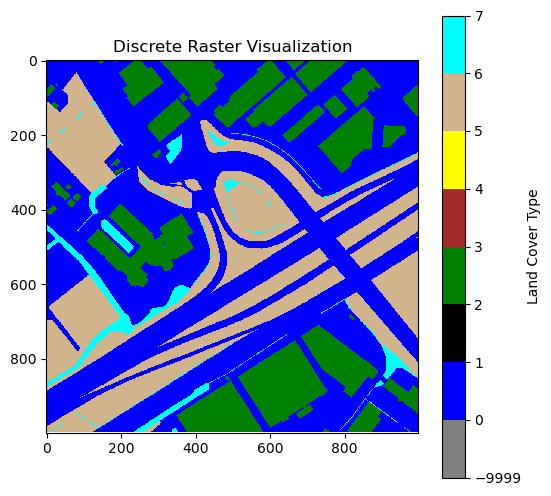

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [5., 5., 5., ..., 0., 0., 0.],
       [5., 5., 5., ..., 0., 0., 0.],
       [5., 5., 5., ..., 0., 0., 0.]], dtype=float32)

In [69]:
convert_to_raster(array, water_features, road_features, terrein_features, buildingdata, dst.transform)


In [ ]:
from pyproj import Transformer

# RD New (EPSG:28992) bounding box
xmin, ymin, xmax, ymax = 94500, 469500, 95000, 470000

# Define transformer from EPSG:28992 (RD New) to EPSG:4326 (WGS84)
transformer = Transformer.from_crs("EPSG:28992", "EPSG:4326", always_xy=True)

# Convert coordinates
lon_min, lat_min = transformer.transform(xmin, ymin)
lon_max, lat_max = transformer.transform(xmax, ymax)

# Print transformed bounding box in CRS84
bbox_crs84 = f"{lon_min},{lat_min},{lon_max},{lat_max}"
print("Bounding Box in CRS84:", bbox_crs84)

In [31]:
features = terreindata.get("features", [])

if features:
    # Extract geometries
    geometries = [shape(feature["geometry"]) for feature in features]

    # Create GeoDataFrame
    gdf = gpd.GeoDataFrame(geometry=geometries, crs="EPSG:28992")

    # Plot data
    fig, ax = plt.subplots(figsize=(8, 8))
    gdf.plot(ax=ax, color="blue", edgecolor="black", alpha=0.5)
    ax.set_title(f"{item_type} (Amersfoort RD New)")
    plt.show()
    
    output_file = "archive/geojson/terrein_vlak.geojson"
    gdf.to_file(output_file, driver="GeoJSON")

NameError: name 'terreindata' is not defined

In [ ]:
print(terreindata)

In [ ]:
import math
import requests

def rd_to_tile(x_min_rd, y_min_rd, x_max_rd, y_max_rd, zoom):
    # RD New tiling scheme parameters
    ORIGIN_X, ORIGIN_Y = -285401.92, 903401.92  # Top-left origin
    TILE_MATRIX_SIZE = 2048  # Number of tiles at zoom level 11
    CELL_SIZE = 1.68  # Cell size at zoom level 11

    # Compute tile indices
    tile_x_min = int((x_min_rd - ORIGIN_X) / (TILE_MATRIX_SIZE * CELL_SIZE))
    tile_y_min = int((ORIGIN_Y - y_max_rd) / (TILE_MATRIX_SIZE * CELL_SIZE))
    tile_x_max = int((x_max_rd - ORIGIN_X) / (TILE_MATRIX_SIZE * CELL_SIZE))
    tile_y_max = int((ORIGIN_Y - y_min_rd) / (TILE_MATRIX_SIZE * CELL_SIZE))

    return tile_x_min, tile_y_min, tile_x_max, tile_y_max

def fetch_tiles(zoom, x_min, y_min, x_max, y_max):
    url_template = "https://api.pdok.nl/brt/top10nl/ogc/v1/tiles/NetherlandsRDNewQuad/{z}/{y}/{x}?f=mvt"
    tiles = []
    for x in range(x_min, x_max + 1):
        for y in range(y_min, y_max + 1):
            tile_url = url_template.format(z=zoom, x=x, y=y)
            response = requests.get(tile_url)
            if response.status_code == 200:
                tiles.append((x, y, response.content))
            else:
                print(f"Failed to fetch tile {x}, {y}")
    return tiles

# Define bounding box (xmin, ymin, xmax, ymax in RD New coordinates)
bbox_rd = (94500, 469500, 95000, 470000)  # Example bounding box
zoom_level = 11

# Compute tile indices
tile_x_min, tile_y_min, tile_x_max, tile_y_max = rd_to_tile(*bbox_rd, zoom_level)

# Fetch tile data
tiles = fetch_tiles(zoom_level, tile_x_min, tile_y_min, tile_x_max, tile_y_max)

# Print results
for tile in tiles:
    print(f"Fetched tile at ({tile[0]}, {tile[1]})")


In [30]:
import math
import requests
import mapbox_vector_tile
import geopandas as gpd
import pandas as pd
from shapely.geometry import shape, Polygon, MultiPolygon
from shapely import affinity
ORIGIN_X, ORIGIN_Y = -285401.92, 903401.92
def tile_to_coordinates(tile_x, tile_y, CELL_SIZE, TILE_WIDTH):
    resolution = TILE_WIDTH * CELL_SIZE
    x_min = ORIGIN_X + tile_x * resolution
    y_max = ORIGIN_Y - tile_y * resolution
    x_max = x_min + resolution
    y_min = y_max - resolution
    return round(x_min, 2), round(y_min, 2), round(x_max, 2), round(y_max, 2)

def rd_to_tile(x_min_rd, y_min_rd, x_max_rd, y_max_rd, TILE_MATRIX_SIZE, CELL_SIZE, TILE_WIDTH):
    # Compute tile indices
    tile_x_min = int((x_min_rd - ORIGIN_X) / (TILE_WIDTH * CELL_SIZE))
    tile_y_min = int((ORIGIN_Y - y_max_rd) / (TILE_WIDTH * CELL_SIZE))
    tile_x_max = int((x_max_rd - ORIGIN_X) / (TILE_WIDTH * CELL_SIZE))
    tile_y_max = int((ORIGIN_Y - y_min_rd) / (TILE_WIDTH * CELL_SIZE))

    tile_x_min = max(0, min(tile_x_min, TILE_MATRIX_SIZE - 1))
    tile_y_min = max(0, min(tile_y_min, TILE_MATRIX_SIZE - 1))
    tile_x_max = max(0, min(tile_x_max, TILE_MATRIX_SIZE - 1))
    tile_y_max = max(0, min(tile_y_max, TILE_MATRIX_SIZE - 1))

    return tile_x_min, tile_y_min, tile_x_max, tile_y_max

def fetch_and_parse_tiles(zoom, x_min, y_min, x_max, y_max, CELL_SIZE):
    url_template = "https://api.pdok.nl/brt/top10nl/ogc/v1/tiles/NetherlandsRDNewQuad/{z}/{y}/{x}?f=mvt"
    all_features = []

    # Calculate scale based on the zoom level
    scale_factor = TILE_WIDTH * CELL_SIZE

    for x in range(x_min, x_max + 1):
        for y in range(y_min, y_max + 1):
            tile_url = url_template.format(z=zoom, x=x, y=y)
            print(f"Fetching tile: {tile_url}")
            response = requests.get(tile_url)

            if response.status_code == 200:
                mvt_data = response.content
                tile = mapbox_vector_tile.decode(mvt_data)

                # Get the bounding box for the current tile (global coordinates)
                x_min_tile, y_min_tile, x_max_tile, y_max_tile = tile_to_coordinates(x, y, CELL_SIZE, TILE_WIDTH)
                print(x_min_tile, y_min_tile, x_max_tile, y_max_tile)

                center_x = (x_min_tile + x_max_tile) / 2
                center_y = (y_min_tile + y_max_tile) / 2


                # Extract features from the parsed MVT tile
                for layer_name, layer in tile.items():
                    for feature in layer['features']:
                        geometry = shape(feature['geometry'])

                        if isinstance(geometry, (Polygon, MultiPolygon)):
                            properties = feature['properties']

                            if geometry.is_valid:
                                local_center=(2048,2048)
                                x_scale = (x_max_tile - x_min_tile) / scale_factor
                                y_scale = (y_max_tile - y_min_tile) / scale_factor
                                geometry = affinity.scale(geometry, xfact=1/scale_factor, yfact=1/scale_factor, origin=local_center)

                                x_offset = x_min_tile
                                y_offset = y_max_tile

                                geometry = affinity.translate(geometry, xoff=x_offset, yoff=y_offset)

                            # S Check if any of the specified properties are not null
                            if (properties.get('typegeografischgebied') is not None or
                                properties.get('typeregistratiefgebied') is not None or
                                properties.get('isbagwoonplaats') is not None or
                                properties.get('typefunctioneelgebied') is not None or
                                properties.get('typegebouw') is not None):
                                continue

                            # Otherwise, append the feature to the list
                            all_features.append({'geometry': geometry, 'properties': properties})
            else:
                print(f"Failed to fetch tile {x}, {y} - Status Code: {response.status_code}")

    gdf = gpd.GeoDataFrame(all_features)

    # Expand properties and set CRS
    properties_df = pd.json_normalize(gdf['properties'])
    gdf_expanded = pd.concat([gdf.drop(columns='properties'), properties_df], axis=1)
    gdf_expanded = gpd.GeoDataFrame(gdf_expanded, geometry='geometry')

    print(gdf_expanded.head())
    gdf_expanded.set_crs("EPSG:28992", inplace=True)  # RD New CRS
    try:
        gdf_expanded.to_file("newtest.geojson", driver="GeoJSON")
        print("GeoJSON saved successfully!")
    except Exception as e:
        print(f"Error saving GeoJSON: {e}")

    return gdf_expanded

bbox_rd = (94500, 469500, 95000, 470000)
TILE_MATRIX_SIZE = 2048
TILE_WIDTH = 256
CELL_SIZE = 1.68
zoom_level = 11

# Compute tile indices
tile_x_min, tile_y_min, tile_x_max, tile_y_max = rd_to_tile(*bbox_rd, TILE_MATRIX_SIZE, CELL_SIZE, TILE_WIDTH)

# Fetch tile data
tiles = fetch_and_parse_tiles(zoom_level, tile_x_min, tile_y_min, tile_x_max, tile_y_max, CELL_SIZE)



Fetching tile: https://api.pdok.nl/brt/top10nl/ogc/v1/tiles/NetherlandsRDNewQuad/11/1007/883?f=mvt
94358.72 469881.28 94788.8 470311.36
Fetching tile: https://api.pdok.nl/brt/top10nl/ogc/v1/tiles/NetherlandsRDNewQuad/11/1008/883?f=mvt
94358.72 469451.2 94788.8 469881.28
Fetching tile: https://api.pdok.nl/brt/top10nl/ogc/v1/tiles/NetherlandsRDNewQuad/11/1007/884?f=mvt
94788.8 469881.28 95218.88 470311.36
Fetching tile: https://api.pdok.nl/brt/top10nl/ogc/v1/tiles/NetherlandsRDNewQuad/11/1008/884?f=mvt
94788.8 469451.2 95218.88 469881.28
                                            geometry   namespace   lokaalid  \
0  POLYGON ((96402.935 472359.983, 96401.474 4723...  NL.TOP10NL  107578466   
1  POLYGON ((96402.142 472360.925, 96402.067 4723...  NL.TOP10NL  107599362   
2  POLYGON ((96402.274 472364.331, 96402.265 4723...  NL.TOP10NL  107612183   
3  POLYGON ((96406.427 472361.618, 96406.683 4723...  NL.TOP10NL  107591868   
4  POLYGON ((96409.220 472361.264, 96409.050 4723...  NL.TOP10N

In [ ]:
response = requests.get("https://api.pdok.nl/brt/top10nl/ogc/v1/tiles/NetherlandsRDNewQuad/10/500/500?f=mvt")


In [ ]:
print(response.content)